In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from templates import *

In [32]:
device = 'cuda:1'
conf = biobank_autoenc()
# conf = ffhq128_autoenc_130M()
print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Seed set to 0


biobank
Model params: 155.43 M


In [33]:
data = ImageDataset('imgs_interpolate', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
data = UKBB_lmdb()
batch = torch.stack([
    data[10]['img'],
    data[11]['img'],
])


In [34]:
for i in range(100):
    data[i]

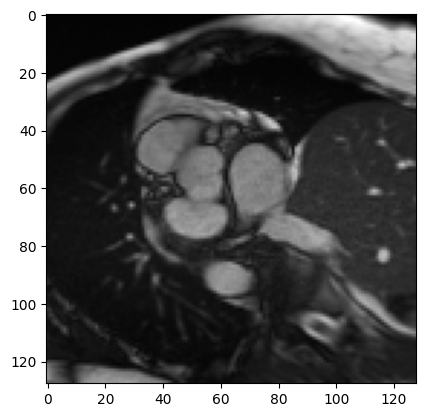

In [35]:
import matplotlib.pyplot as plt
# batch = batch *2 -1
plt.imshow((batch[0].permute([1, 2, 0]) + 1)/2  )

In [40]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=1000)
# xT = torch.randn_like(xT)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


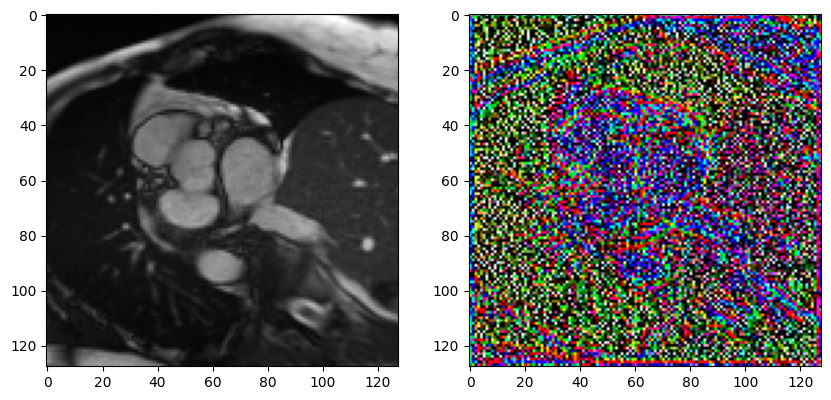

In [41]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch +1 ) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

# Interpolate

Semantic codes are interpolated using convex combination, while stochastic codes are interpolated using spherical linear interpolation.

In [42]:
import numpy as np
alpha = torch.tensor(np.linspace(0, 1, 10, dtype=np.float32)).to(cond.device)
intp = cond[0][None] * (1 - alpha[:, None]) + cond[1][None] * alpha[:, None]

def cos(a, b):
    a = a.view(-1)
    b = b.view(-1)
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()

theta = torch.arccos(cos(xT[0], xT[1]))
x_shape = xT[0].shape
intp_x = (torch.sin((1 - alpha[:, None]) * theta) * xT[0].flatten(0, 2)[None] + torch.sin(alpha[:, None] * theta) * xT[1].flatten(0, 2)[None]) / torch.sin(theta)
intp_x = intp_x.view(-1, *x_shape)

pred = model.render(intp_x, intp, T=250)

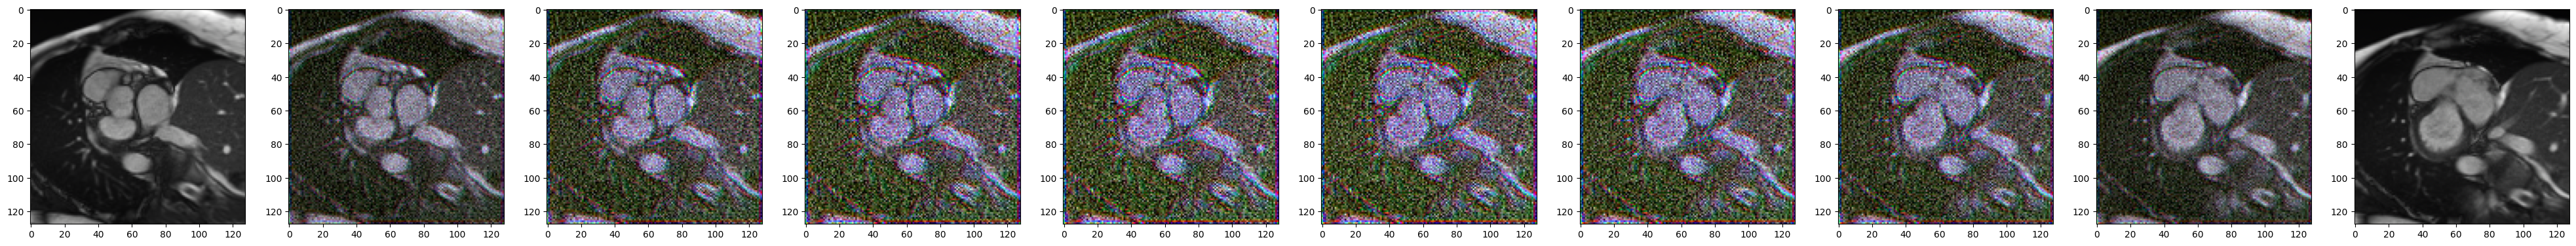

In [43]:
import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 10, figsize=(5*10, 5))
for i in range(len(alpha)):
    ax[i].imshow(pred[i].permute(1, 2, 0).cpu())
# plt.savefig('imgs_manipulated/compare.png')